# Import Library

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc
import os
import cv2
import shutil

# Load Dataset

In [4]:
def load_dataset(dataset_path):
  """Loads the dataset from the given path.

  Args:
    dataset_path: Path to the dataset directory.

  Returns:
    A tuple containing the image data and corresponding labels.
  """

  images = []
  labels = []

  class_names = os.listdir(dataset_path)
  for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
      for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
          # Resize images to a consistent size
          image = cv2.resize(image, (224, 224))  # Example size, adjust as needed
          images.append(image)
          labels.append(class_name)

  return np.array(images), np.array(labels)


# Load the dataset
dataset_path = r"D:\kuliah\ML\praktikum\UAP\dataset"
images, labels = load_dataset(dataset_path)

# Eda

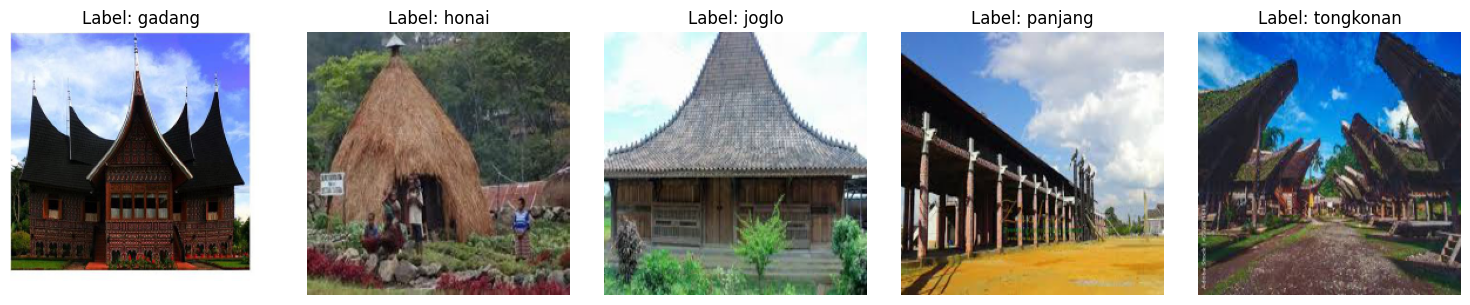

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

unique_labels = np.unique(labels)

# Tentukan jumlah kolom untuk grid (misalnya 4)
num_cols = 5
num_rows = (len(unique_labels) + num_cols - 1) // num_cols  # Hitung jumlah baris

plt.figure(figsize=(15, num_rows * 3))  # Sesuaikan ukuran grid
for i, label in enumerate(unique_labels):
    # Cari indeks gambar yang sesuai dengan label saat ini
    indices = np.where(labels == label)[0]

    # Pilih gambar acak dari label tersebut
    random_index = np.random.choice(indices)
    image = images[random_index]

    # Tambahkan subplot untuk setiap gambar
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Konversi dari BGR ke RGB
    plt.title(f"Label: {label}")
    plt.axis("off")  # Hilangkan sumbu

plt.tight_layout()  # Tata letak agar lebih rapi
plt.show()


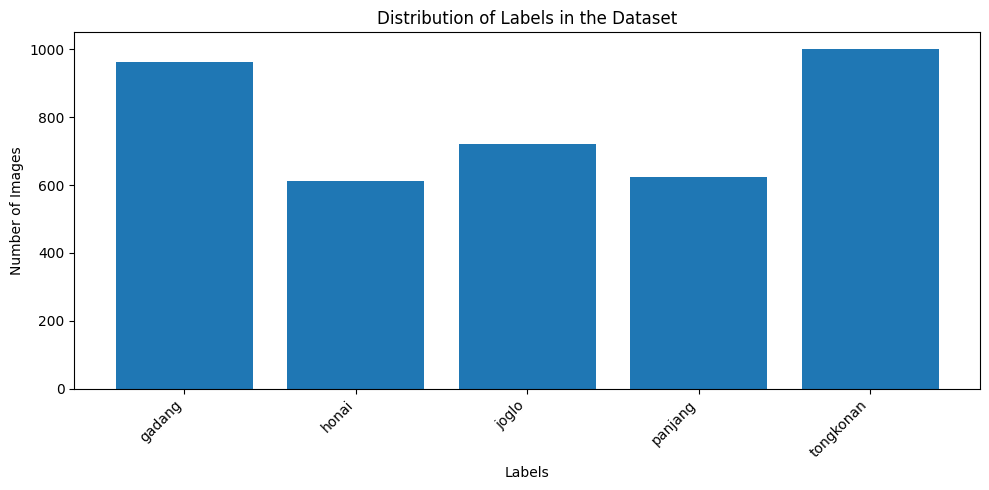

In [18]:
# Calculate the distribution of labels
label_counts = {}
for label in labels:
  if label not in label_counts:
    label_counts[label] = 0
  label_counts[label] += 1

# Create a bar chart to visualize the label distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Labels")
plt.ylabel("Number of Images")
plt.title("Distribution of Labels in the Dataset")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

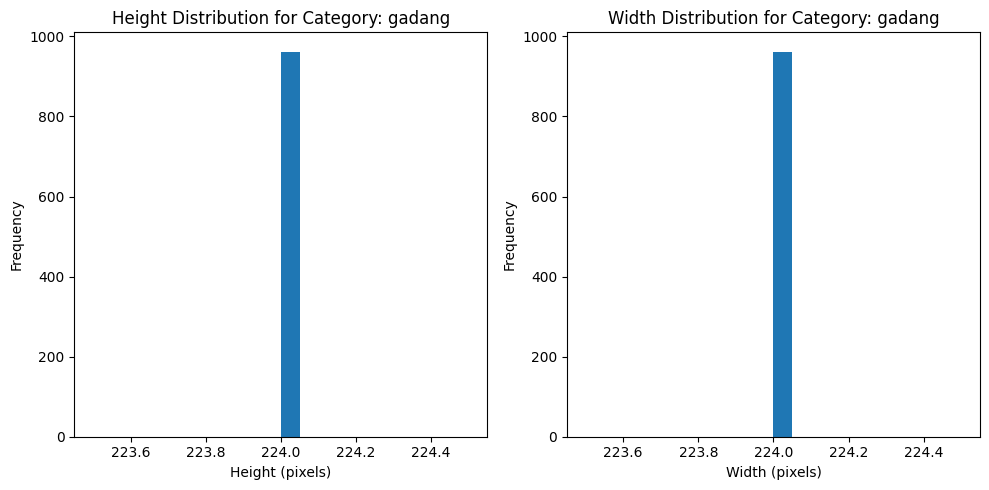

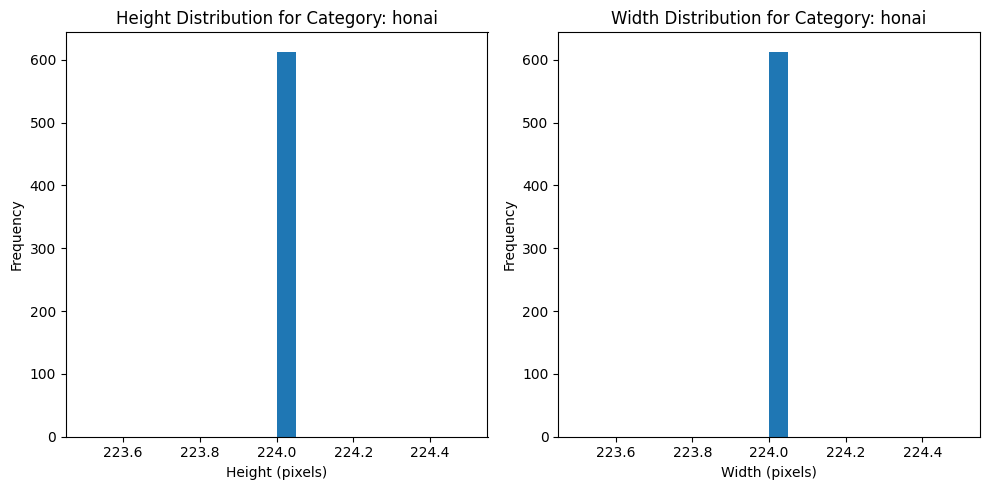

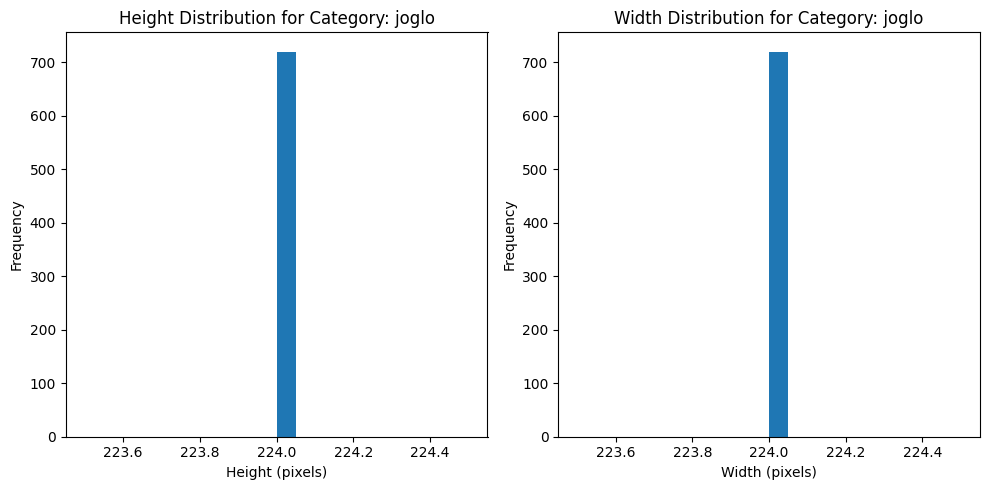

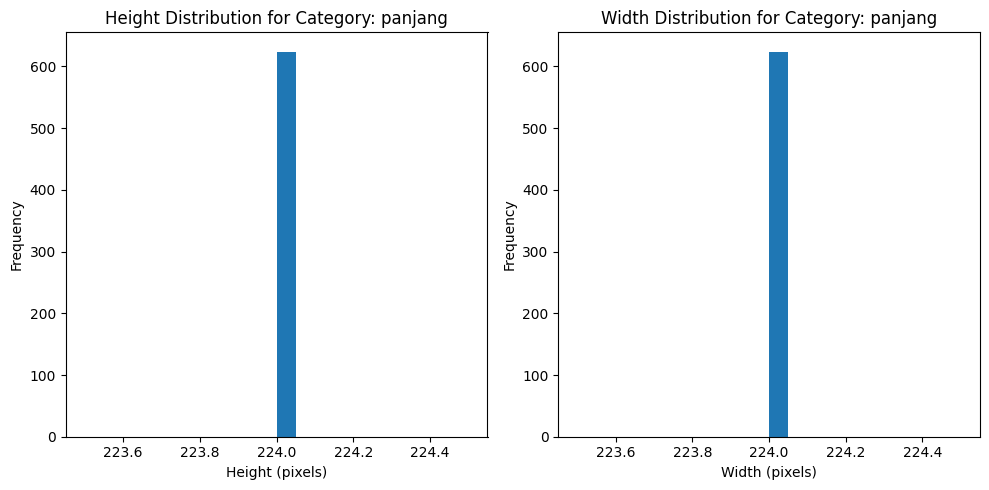

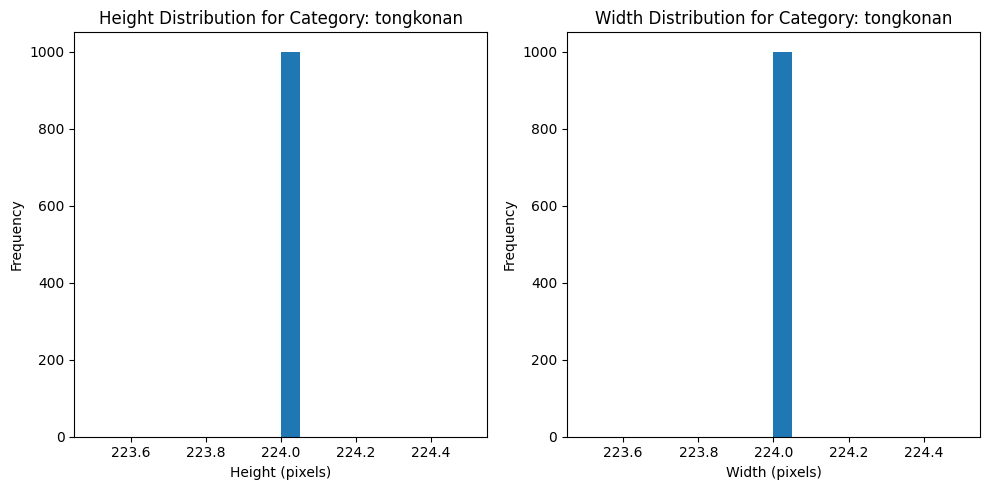

In [17]:
for label in unique_labels:
  # Find indices of images belonging to the current label
  indices = np.where(labels == label)[0]

  # Extract images for the current label
  label_images = images[indices]

  # Get image dimensions
  image_heights = [img.shape[0] for img in label_images]
  image_widths = [img.shape[1] for img in label_images]

  # Plot the distribution of image heights and widths
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.hist(image_heights, bins=20)
  plt.xlabel("Height (pixels)")
  plt.ylabel("Frequency")
  plt.title(f"Height Distribution for Category: {label}")

  plt.subplot(1, 2, 2)
  plt.hist(image_widths, bins=20)
  plt.xlabel("Width (pixels)")
  plt.ylabel("Frequency")
  plt.title(f"Width Distribution for Category: {label}")

  plt.tight_layout()
  plt.show()


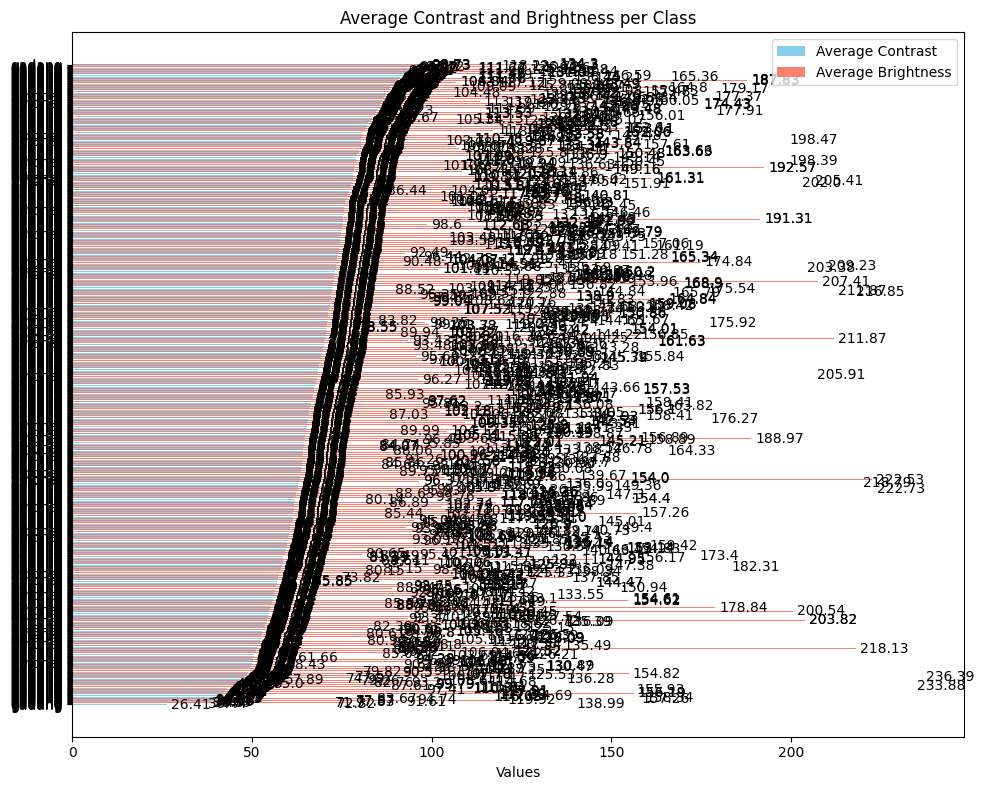

In [20]:
def calculate_average_contrast_brightness(images):
    """Calculates the average contrast and brightness for a list of images."""
    contrasts = []
    brightnesses = []
    for img in images:
        if img is None:  # Skip invalid images
            continue
        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Calculate contrast using standard deviation
        contrast = np.std(gray)
        contrasts.append(contrast)

        # Calculate brightness using mean pixel intensity
        brightness = np.mean(gray)
        brightnesses.append(brightness)

    return np.array(contrasts), np.array(brightnesses)

unique_labels = np.unique(labels)
avg_contrasts_per_class = {}
avg_brightnesses_per_class = {}

for label in unique_labels:
    # Get images for the current label
    class_images = images[labels == label]
    if len(class_images) == 0:
        print(f"Skipping label: {label} (no images)")
        continue

    # Calculate average contrast and brightness for the images in this class
    contrasts, brightnesses = calculate_average_contrast_brightness(class_images)
    avg_contrasts_per_class[label] = np.mean(contrasts)
    avg_brightnesses_per_class[label] = np.mean(brightnesses)

# Sort data by contrast for better visualization
if len(contrasts) > 0 and len(brightnesses) > 0:
    sorted_indices = np.argsort(contrasts)
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_contrasts = [contrasts[i] for i in sorted_indices]
    sorted_brightnesses = [brightnesses[i] for i in sorted_indices]
else:
    print("No valid data for plotting.")
    sorted_labels, sorted_contrasts, sorted_brightnesses = [], [], []

# Plotting (if there is valid data)
if len(sorted_labels) > 0:
    x = np.arange(len(sorted_labels))  # the label locations

    fig, ax = plt.subplots(figsize=(10, 8))

    # Create horizontal bars
    rects1 = ax.barh(x - 0.2, sorted_contrasts, 0.4, label='Average Contrast', color='skyblue')
    rects2 = ax.barh(x + 0.2, sorted_brightnesses, 0.4, label='Average Brightness', color='salmon')

    # Add labels, title, and legend
    ax.set_xlabel('Values')
    ax.set_title('Average Contrast and Brightness per Class')
    ax.set_yticks(x)
    ax.set_yticklabels(sorted_labels)
    ax.legend()

    # Add labels above bars
    def autolabel_horizontal(rects):
        for rect in rects:
            width = rect.get_width()
            ax.annotate('{}'.format(round(width, 2)),
                        xy=(width, rect.get_y() + rect.get_height() / 2),
                        xytext=(3, 0),
                        textcoords="offset points",
                        ha='left', va='center')

    autolabel_horizontal(rects1)
    autolabel_horizontal(rects2)

    fig.tight_layout()
    plt.show()

# Augmentasi

In [ ]:
import os
import random

# Path ke dataset
base_path = r"D:\kuliah\ML\praktikum\UAP\dataset"

# Jumlah target maksimal per kelas
target_count = 600

# Menghapus gambar berlebih
for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        # Mendapatkan file gambar di folder kelas
        files = os.listdir(label_path)
        current_count = len(files)

        # Jika jumlah gambar lebih dari target_count
        if current_count > target_count:
            print(f"Menghapus {current_count - target_count} gambar dari kelas {label}...")
            
            # Memilih gambar secara acak untuk dihapus
            files_to_delete = random.sample(files, current_count - target_count)
            for file_name in files_to_delete:
                file_path = os.path.join(label_path, file_name)
                os.remove(file_path)

print("Penghapusan gambar berlebih selesai!")


Menghapus 362 gambar dari kelas gadang...
Menghapus 13 gambar dari kelas honai...
Menghapus 120 gambar dari kelas joglo...
Menghapus 24 gambar dari kelas panjang...
Menghapus 400 gambar dari kelas tongkonan...
Penghapusan gambar berlebih selesai!


In [23]:
import cv2
import os
import random
import numpy as np

def color_jitter(image, brightness=0, contrast=0, saturation=0, hue=0):
    """Applies color jittering to an image."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)

    if brightness != 0:
        image[:,:,2] = np.clip(image[:,:,2] * (1 + brightness), 0, 255)

    if contrast != 0:
        mean = np.mean(image[:,:,2])
        image[:,:,2] = np.clip((image[:,:,2] - mean) * (1 + contrast) + mean, 0, 255)

    if saturation != 0:
        image[:,:,1] = np.clip(image[:,:,1] * (1 + saturation), 0, 255)

    if hue != 0:
        image[:,:,0] = (image[:,:,0] + hue * 180) % 180

    image = cv2.cvtColor(np.clip(image, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)

    return image

def augment_image_with_jitter(img, brightness_factor, contrast_factor, saturation_factor, hue_factor):
    """Augments the image by applying color jitter."""
    return color_jitter(img, brightness=brightness_factor, contrast=contrast_factor, saturation=saturation_factor, hue=hue_factor)

def generate_augmented_dataset(input_dir, output_dir, ratio=4, brightness_range=(-0.2, 0.2), contrast_range=(-0.2, 0.2), saturation_range=(-0.2, 0.2), hue_range=(-0.05, 0.05)):
    """Generates augmented dataset using color jittering for brightness, contrast, saturation, and hue adjustments."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_label in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_label)
        output_class_dir = os.path.join(output_dir, class_label)

        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        # Load all images in the class
        images = []
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                else:
                    print(f"Failed to load image: {img_path}")

        if not images:
            print(f"No valid images in directory: {class_dir}")
            continue

        num_original_images = len(images)
        num_augmented_per_image = ratio

        for idx, img in enumerate(images):
            # Save the original image
            original_path = os.path.join(output_class_dir, f"{class_label}_original_{idx}.jpg")
            cv2.imwrite(original_path, img)

            # Generate augmented images using color jittering
            for i in range(num_augmented_per_image):
                brightness_factor = random.uniform(*brightness_range)
                contrast_factor = random.uniform(*contrast_range)
                saturation_factor = random.uniform(*saturation_range)
                hue_factor = random.uniform(*hue_range)

                augmented_img = augment_image_with_jitter(img, brightness_factor, contrast_factor, saturation_factor, hue_factor)

                augmented_path = os.path.join(output_class_dir, f"{class_label}_augmented_{idx}_{i}.jpg")
                cv2.imwrite(augmented_path, augmented_img)

# Define input and output directories
input_dir = r"D:\kuliah\ML\praktikum\UAP\dataset"
output_dir = r"D:\kuliah\ML\praktikum\UAP\dataset_augmentasi"

# Generate augmented dataset with a ratio of 1:1
generate_augmented_dataset(input_dir, output_dir, ratio=3)


# Preproccess

In [26]:
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Splits a dataset into training, validation, and testing sets.

    Args:
        source_dir: Path to the source dataset directory.
        train_dir: Path to the directory for the training set.
        val_dir: Path to the directory for the validation set.
        test_dir: Path to the directory for the testing set.
        train_ratio: Proportion of data for training.
        val_ratio: Proportion of data for validation.
        test_ratio: Proportion of data for testing.
    """

    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            random.shuffle(images)
            num_images = len(images)
            num_train = int(num_images * train_ratio)
            num_val = int(num_images * val_ratio)
            num_test = num_images - num_train - num_val

            for i, image in enumerate(images):
                source_image_path = os.path.join(class_path, image)
                if i < num_train:
                    destination_image_path = os.path.join(train_class_dir, image)
                elif i < num_train + num_val:
                    destination_image_path = os.path.join(val_class_dir, image)
                else:
                    destination_image_path = os.path.join(test_class_dir, image)

                shutil.copy(source_image_path, destination_image_path)

# Example usage
source_directory = r"D:\kuliah\ML\praktikum\UAP\dataset_augmentasi"  # Replace with the path to your dataset
train_directory = r"D:\kuliah\ML\praktikum\UAP\DATASET_SPLIT\train"
validation_directory = r"D:\kuliah\ML\praktikum\UAP\DATASET_SPLIT\validation"
test_directory = r"D:\kuliah\ML\praktikum\UAP\DATASET_SPLIT\test"

split_dataset(source_directory, train_directory, validation_directory, test_directory)

# Model CNN

Found 8400 images belonging to 5 classes.
Found 1800 images belonging to 5 classes.
Number of classes: 5
Class names: {'gadang': 0, 'honai': 1, 'joglo': 2, 'panjang': 3, 'tongkonan': 4}
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )         

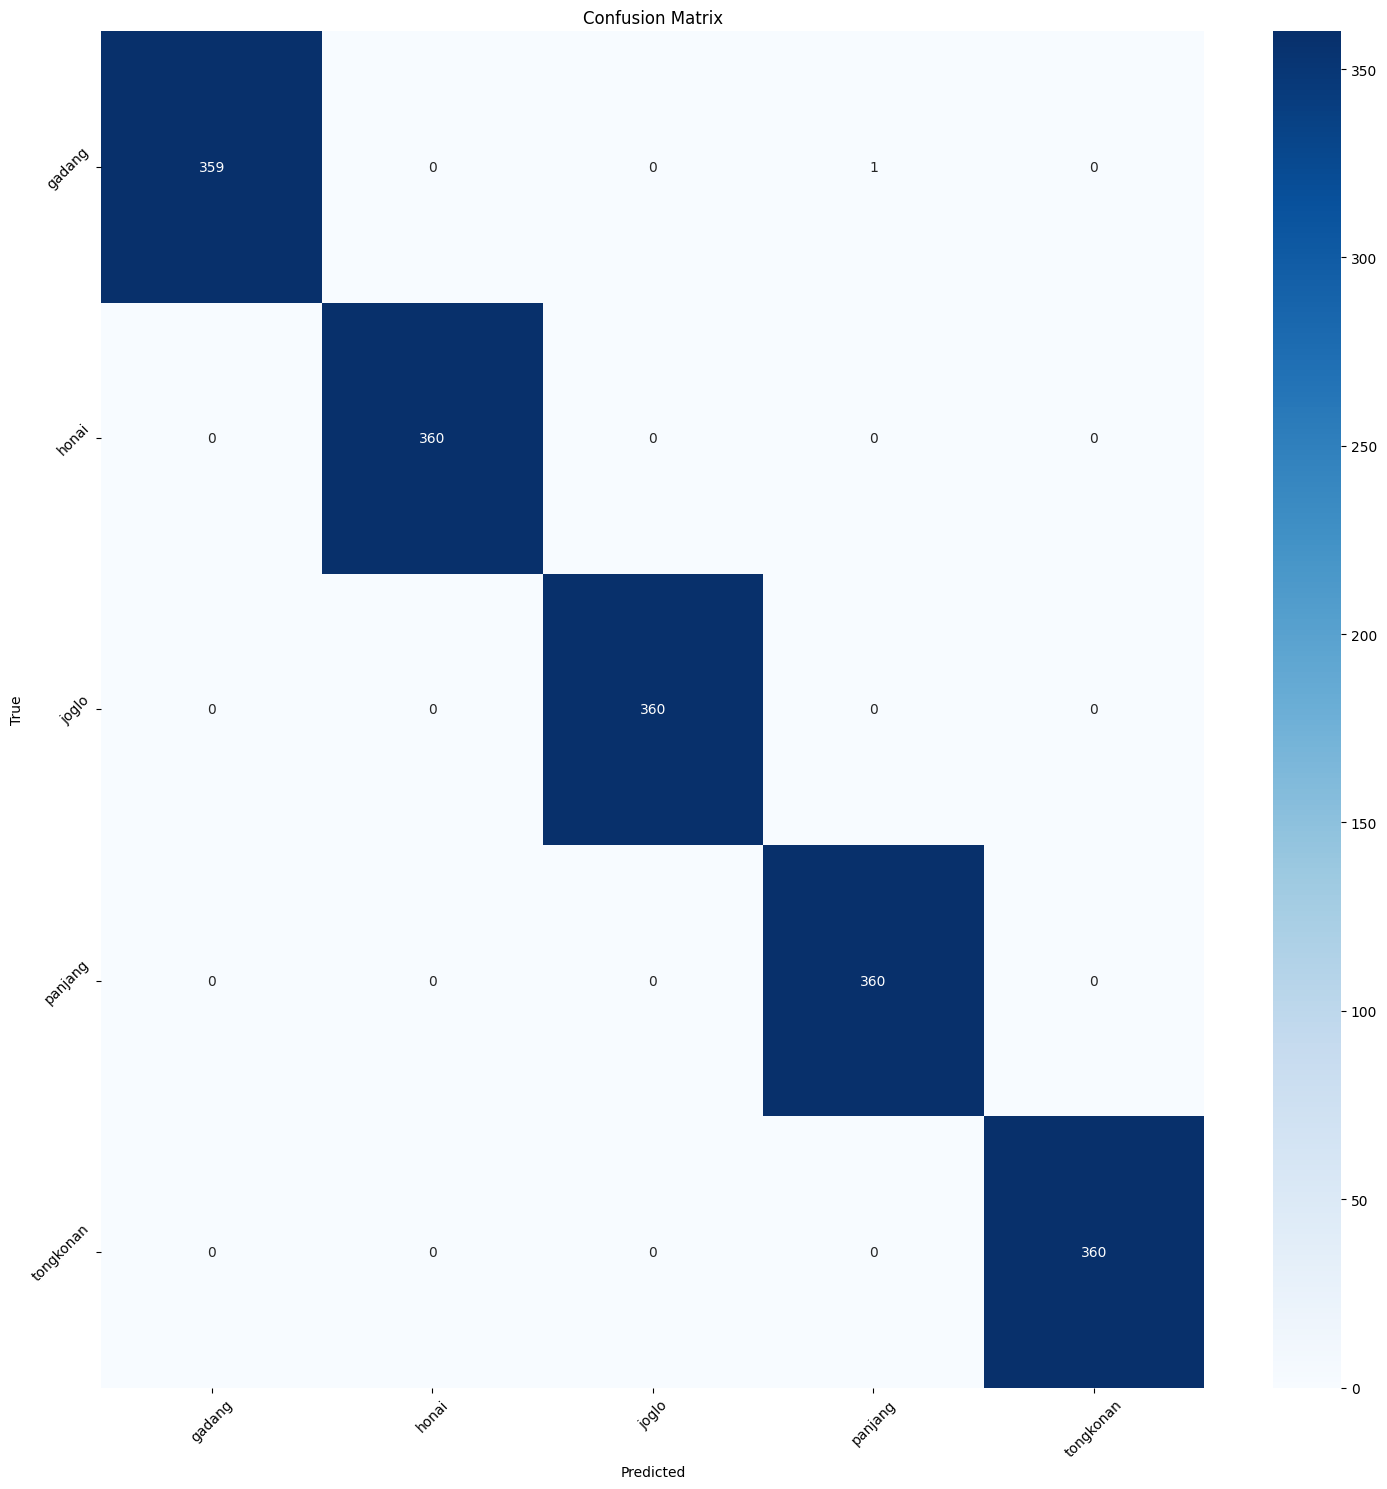

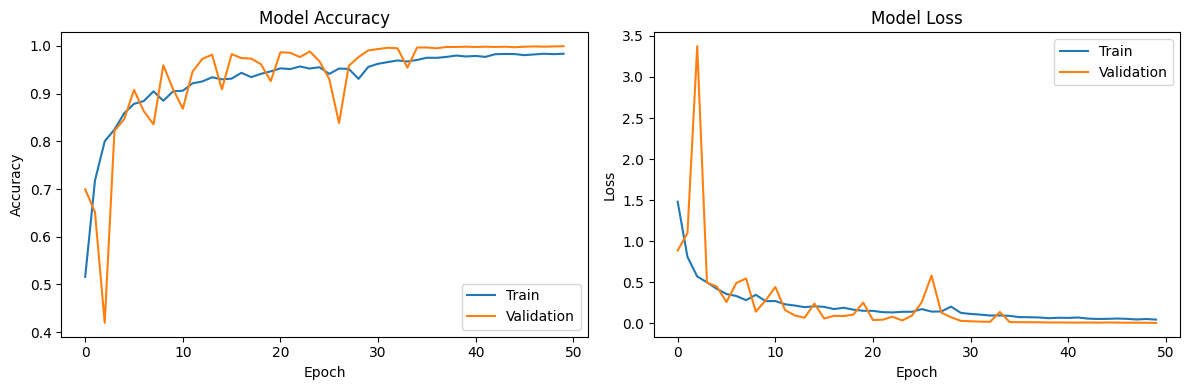

14759

In [2]:
# Memory cleanup and GPU settings
def setup_gpu():
    tf.keras.backend.clear_session()
    gc.collect()
    
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Limit GPU memory to 3GB
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=3072)]
            )
    except:
        pass

setup_gpu()

# Directory settings
base_dir = r"D:\kuliah\ML\praktikum\UAP\dataset_split"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print("Class names:", train_generator.class_indices)

# Efficient CNN Model
model = Sequential([
    # First Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Second Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Third Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Fourth Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Use mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Compile model
optimizer = Adam(learning_rate=0.001)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Classification Report
print("\nClassification Report:")
class_names = list(train_generator.class_indices.keys())
cr = classification_report(y_true, y_pred, target_names=class_names)
print(cr)

# Confusion Matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Training History Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Save the model
model.save('omah_classification_model.h5')

# Memory cleanup
tf.keras.backend.clear_session()
gc.collect()

# Model RESNET

Found 9600 images belonging to 5 classes.
Found 2400 images belonging to 5 classes.
Phase 1: Training top layers
Epoch 1/10
600/600 [==============================] - 118s 193ms/step - loss: 0.2964 - accuracy: 0.9017 - val_loss: 0.0867 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 2/10
600/600 [==============================] - 88s 147ms/step - loss: 0.1194 - accuracy: 0.9622 - val_loss: 0.0728 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 3/10
600/600 [==============================] - 182s 304ms/step - loss: 0.1166 - accuracy: 0.9639 - val_loss: 0.0699 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 4/10
600/600 [==============================] - 95s 158ms/step - loss: 0.0861 - accuracy: 0.9732 - val_loss: 0.0665 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 5/10
600/600 [==============================] - 93s 155ms/step - loss: 0.0842 - accuracy: 0.9741 - val_loss: 0.0711 - val_accuracy: 0.9804 - lr: 0.0010
Epoch 6/10
600/600 [==============================] - 93s 155ms/step - loss: 0.0708 - accuracy:

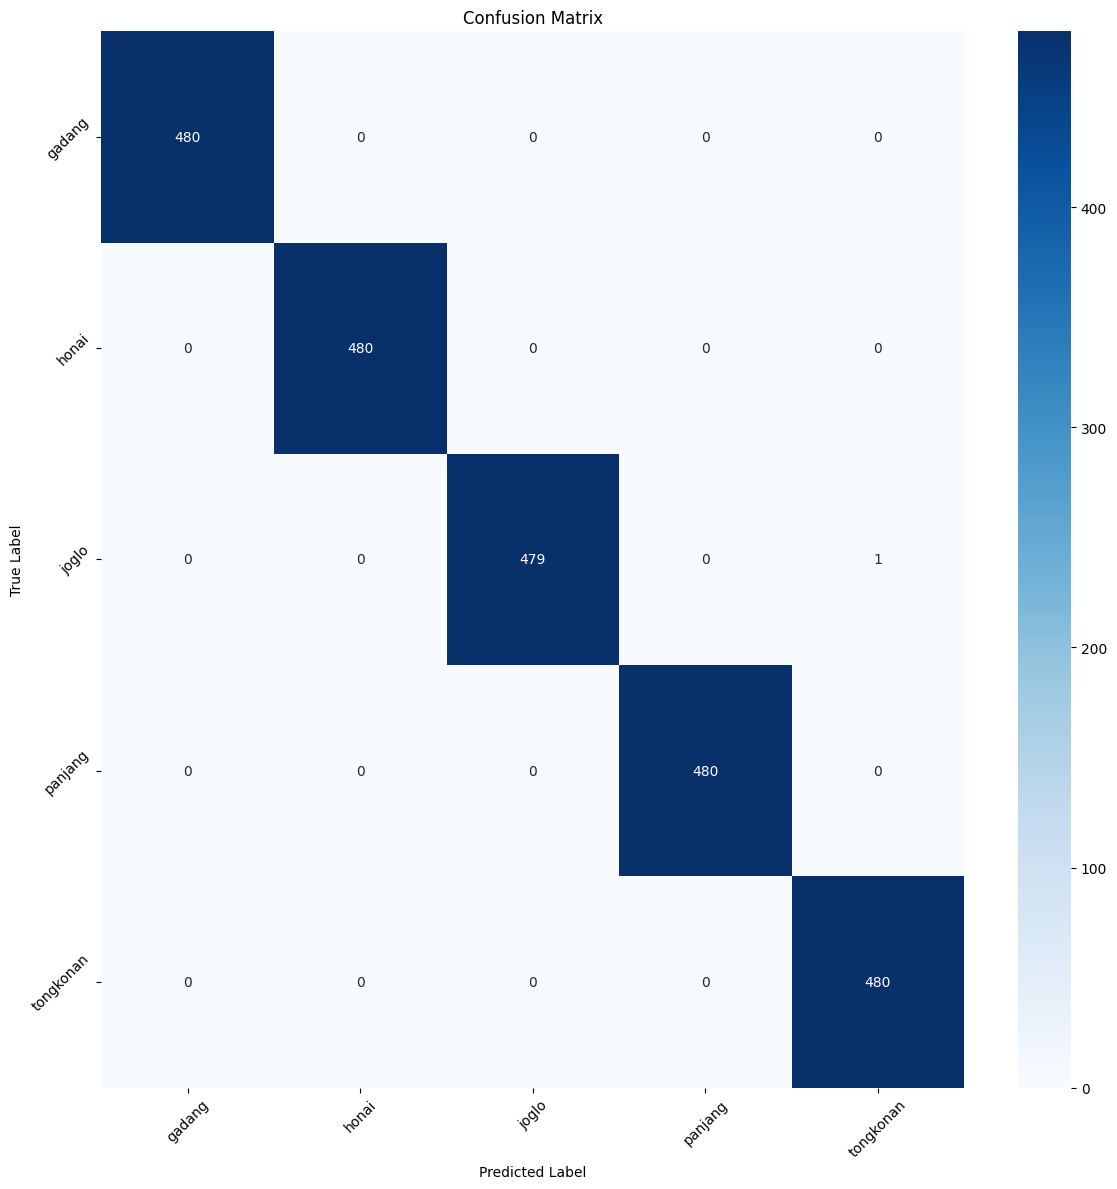

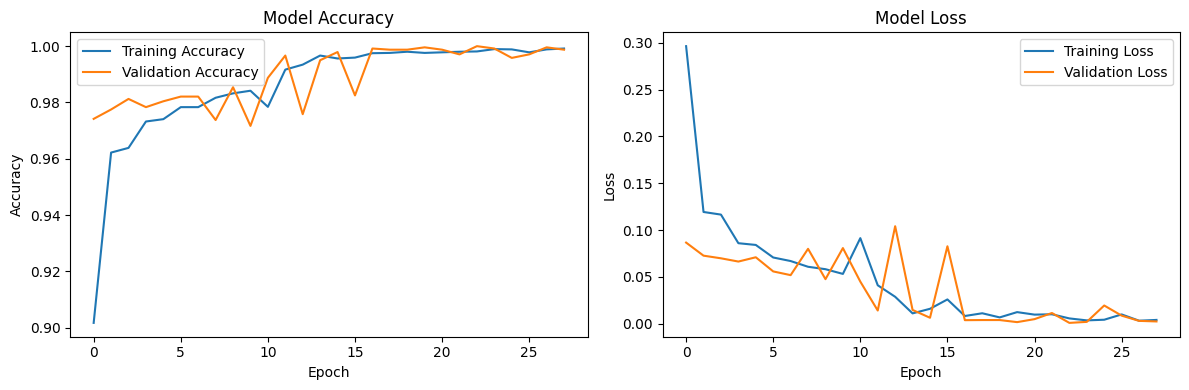

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Konfigurasi parameter
IMG_SIZE = 224  # ResNet default size
BATCH_SIZE = 16
EPOCHS = 50
NUM_CLASSES = 5

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    r'D:\kuliah\ML\praktikum\UAP\dataset_augmentasi',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    r'D:\kuliah\ML\praktikum\UAP\dataset_augmentasi',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

def create_model():
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

# Create model with mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

model, base_model = create_model()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# First phase: Train only the top layers
print("Phase 1: Training top layers")
history1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Second phase: Fine-tune ResNet layers
print("Phase 2: Fine-tuning ResNet layers")
# Unfreeze the last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile model with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

def evaluate_model(model, generator):
    predictions = []
    labels = []
    
    print("Evaluating model...")
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]
        batch_pred = model.predict(batch_images, verbose=0)
        predictions.extend(np.argmax(batch_pred, axis=1))
        labels.extend(np.argmax(batch_labels, axis=1))
        if len(labels) >= len(generator.labels):
            break
    
    # Get class names
    class_names = list(generator.class_indices.keys())
    
    # Classification Report
    cr = classification_report(labels, predictions, target_names=class_names)
    print("\nClassification Report:")
    print(cr)
    
    # Confusion Matrix
    plt.figure(figsize=(12, 12))
    cm = confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_training_history(history1, history2):
    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Evaluate and plot results
evaluate_model(model, validation_generator)
plot_training_history(history1, history2)


In [19]:
# Save model
model.save('resnet50_transfer_model.h5')

In [1]:
import seaborn as sns
print(sns.__version__)


0.13.2
